# ASHRAE - Great Energy Predictor III
https://www.kaggle.com/competitions/ashrae-energy-prediction/overview

LightGBMをやってみる  
参考  
https://www.kaggle.com/code/aitude/ashrae-kfold-lightgbm-without-leak-1-08  

LightGBM パラメーター内容  
https://zenn.dev/mosamosa/articles/07d0076c9292136a3639

In [1]:
# 定数定義
DATA_PATH = "./data"
""" データディレクトリ """

' データディレクトリ '

In [2]:
# インポート定義

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import datetime
import gc
import os
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

In [83]:
# データ読み込み
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))

# Remove outliers
# TODO:なぜこの条件で除外しているかの確認が必要
train_df = train_df [ train_df['building_id'] != 1099 ]
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

building_df = pd.read_csv(os.path.join(DATA_PATH, 'building_metadata.csv'))
weather_df = pd.read_csv(os.path.join(DATA_PATH, 'weather_train.csv'))

In [3]:
# Original code from https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling by @aitude

def fill_weather_dataset(weather_df: pd.DataFrame) -> pd.DataFrame:
    """気象データの欠損値を補完する

    Args:
        weather_df (pd.DataFrame): 気象データ

    Returns:
        pd.DataFrame: データ補完後の気象データを返す
    """
    # サイトIDの数
    SITE_ID_COUNT = 16

    # 気象データの観測時間リストを作成
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    # サイト毎に欠損データを追加
    # ※追加するデータの値はnanを設定
    for site_id in range(SITE_ID_COUNT):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)

    # 観測日時より、日、週、月のカラムを作成
    # ※後述の追加カラムのため
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month

    # 欠損値を補完    
    # データ集計の高速化のため、集計単位でインデックスを作成
    weather_df = weather_df.set_index(['site_id','day','month'])

    # 気温
    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # 雲量
    # Step 1 グループ毎の平均値を取得
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    # Step 2 直前に値が設定されている場合、その値を使用する
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])

    weather_df.update(cloud_coverage_filler,overwrite=False)

    # 露点温度(≒湿度)
    dew_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(dew_temperature_filler, overwrite=False)

    # 海面気圧
    # Step 1 グループ毎の平均値を取得
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    # Step 2 直前に値が設定されている場合、その値を使用する
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])

    weather_df.update(sea_level_filler,overwrite=False)

    # 風向き
    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)

    # 風速
    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # 降水量
    # Step 1 グループ毎の平均値を取得
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2 直前に値が設定されている場合、その値を資料する
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])

    weather_df.update(precip_depth_filler,overwrite=False)

    # インデックスを再作成し、欠損値補完用に追加したカラムを削除
    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
        
    return weather_df

In [4]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin

def reduce_mem_usage(df: pd.DataFrame, use_float16: bool = False) -> pd.DataFrame:
    """ロードしたデータを型変換し、容量を削減する

    Args:
        df (pd.DataFrame): ロードデータ
        use_float16 (bool, optional): float16使用フラグ デフォルト値：False

    Returns:
        pd.DataFrame: 容量削減後のデータを返す
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
def features_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """特徴量を作成する

    Args:
        df (pd.DataFrame): ロードしたデータ

    Returns:
        pd.DataFrame: 特徴量を追加したデータ
    """
    
    # 時系列順にソートする
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    # Add more features
    # 日時
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    
    # 時間
    df["hour"] = df["timestamp"].dt.hour
    
    # 曜日
    df["weekend"] = df["timestamp"].dt.weekday
    
    # 総床面積 ※logでは0が設定された場合に-∞になるため、log(1+a)にする
    df["square_feet"] = np.log1p(df["square_feet"])

    # 築年数 ※値が設定されている場合は"1"、その他の場合は"0"を設定
    df["year_built"] = np.where(df["year_built"].notna(), 1, 0)

    # 体感温度 ※風による温度影響を測るため、北風をマイナス値(冷たい風)、南風をプラス値(暖かい風)とし、風速を掛けた値を設定する
    df["wind_direction"] = -np.sin(np.radians(df["wind_direction"] % 360)) 
    df["wind_warn"] = df["wind_direction"] * df["wind_speed"]
    
    # 使用しないカラムを削除する
    drop = ["timestamp","sea_level_pressure", "wind_direction", "wind_speed", "floor_count", "building_id"]
    df = df.drop(drop, axis=1)
    gc.collect()
    
    # Encode Categorical Data
    le = LabelEncoder()
    df["primary_use"] = le.fit_transform(df["primary_use"])
    
    return df

In [87]:
# 気象データの欠損値を補完する
weather_df = fill_weather_dataset(weather_df)

/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_1585/703020239.py:36: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  weather_df["week"] = weather_df["datetime"].dt.week


In [88]:
# データ容量を削減する
train_df = reduce_mem_usage(train_df,use_float16=True)
building_df = reduce_mem_usage(building_df,use_float16=True)
weather_df = reduce_mem_usage(weather_df,use_float16=True)

Memory usage of dataframe is 757.31 MB
Memory usage after optimization is: 322.18 MB
Decreased by 57.5%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.9%
Memory usage of dataframe is 9.65 MB
Memory usage after optimization is: 2.60 MB
Decreased by 73.1%


In [ ]:
# コーディング用にロード、加工したデータを保存する
# TODO:テストコードのため、要削除
# train_df.to_pickle(os.path.join(DATA_PATH, "train_df.pkl"))
# building_df.to_pickle(os.path.join(DATA_PATH, "building_df.pkl"))
# weather_df.to_pickle(os.path.join(DATA_PATH, "weather_df.pkl"))

In [6]:
# コーディング用に保存したデータをロードする
# TODO:テストコードのため、要削除
train_df = pd.read_pickle(os.path.join(DATA_PATH, "train_df.pkl"))
building_df = pd.read_pickle(os.path.join(DATA_PATH, "building_df.pkl"))
weather_df = pd.read_pickle(os.path.join(DATA_PATH, "weather_df.pkl"))

In [7]:
# 各データを結合する
train_df = train_df.merge(building_df, left_on='building_id',right_on='building_id',how='left')
train_df = train_df.merge(weather_df,how='left',left_on=['site_id','timestamp'],right_on=['site_id', 'timestamp'])
del weather_df
gc.collect()

15

In [8]:
# 特徴量を作成する
train_df = features_engineering(train_df)

In [9]:
# データを目的変数と特徴量変数に分割する
target = np.log1p(train_df["meter_reading"])
features = train_df.drop("meter_reading", axis = 1)
del train_df
gc.collect()

15

In [11]:
# カテゴリ変数リスト
categorical_features = ["site_id", "meter", "primary_use", "hour", "weekend", "year_built"]

# パラメーター設定
params = {
    "objective": "regression", # 目的関数：回帰
    "boosting": "gbdt", # 勾配ブースティング
    "seed": 314, #シード値
    "num_leaves": 128, # 決定木の端末ノードの数
    "max_depth": 7, #決定木の深さ
    "learning_rate": 0.05, # 学習率
    "feature_fraction": 0.85, # 特徴量の削減率 ※1未満の場合、特徴量を削減して学習される
    # "reg_lambda": 2, # L2正則化項の係数 ※過学習を防ぐために用いる関数のパラメータ
    "metric": "rmse",# モデルの性能を測る指標 ※二乗平均平方根誤差
    "force_row_wise": True, # 行ベースのヒストグラムを生成する
    "verbose": -1
}

earlyStoppingcallback = early_stopping(50)
logEvaluationCallback = log_evaluation(25)

# 学習実行
kf = KFold(n_splits=3)
models = []
for train_index, test_index in kf.split(features):
    train_features = features.loc[train_index]
    train_target = target.loc[train_index]
    
    test_features = features.loc[test_index]
    test_target = target.loc[test_index]

    # データセット作成    
    d_training = lgb.Dataset(train_features, label=train_target, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target, free_raw_data=False)
    
    # 学習実行
    model = lgb.train(
        params,
        train_set=d_training,
        num_boost_round=2000,
        valid_sets=[d_training, d_test],
        categorical_feature=categorical_features,
        callbacks=[
            earlyStoppingcallback,
            logEvaluationCallback
        ]
    )
    
    models.append(model)
    
    del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()

/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['hour', 'meter', 'primary_use', 'site_id', 'weekend', 'year_built']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.57664	valid_1's rmse: 1.64283
[50]	training's rmse: 1.39903	valid_1's rmse: 1.4571
[75]	training's rmse: 1.32911	valid_1's rmse: 1.39246
[100]	training's rmse: 1.28471	valid_1's rmse: 1.34929
[125]	training's rmse: 1.25216	valid_1's rmse: 1.32393
[150]	training's rmse: 1.22859	valid_1's rmse: 1.30591
[175]	training's rmse: 1.20842	valid_1's rmse: 1.29082
[200]	training's rmse: 1.18825	valid_1's rmse: 1.27784
[225]	training's rmse: 1.17149	valid_1's rmse: 1.2689
[250]	training's rmse: 1.1535	valid_1's rmse: 1.25813
[275]	training's rmse: 1.13956	valid_1's rmse: 1.25052
[300]	training's rmse: 1.12889	valid_1's rmse: 1.24548
[325]	training's rmse: 1.11706	valid_1's rmse: 1.23953
[350]	training's rmse: 1.10405	valid_1's rmse: 1.23247
[375]	training's rmse: 1.09007	valid_1's rmse: 1.2246
[400]	training's rmse: 1.07598	valid_1's rmse: 1.21821
[425]	training's rmse: 1.06613	valid_1's rmse: 1.21357
[450]	train

/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['hour', 'meter', 'primary_use', 'site_id', 'weekend', 'year_built']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[25]	training's rmse: 1.51403	valid_1's rmse: 1.59509
[50]	training's rmse: 1.35236	valid_1's rmse: 1.45786
[75]	training's rmse: 1.29234	valid_1's rmse: 1.40267
[100]	training's rmse: 1.25532	valid_1's rmse: 1.3713
[125]	training's rmse: 1.23029	valid_1's rmse: 1.34792
[150]	training's rmse: 1.21294	valid_1's rmse: 1.33187
[175]	training's rmse: 1.19861	valid_1's rmse: 1.31743
[200]	training's rmse: 1.18504	valid_1's rmse: 1.3059
[225]	training's rmse: 1.16894	valid_1's rmse: 1.29182
[250]	training's rmse: 1.15791	valid_1's rmse: 1.28239
[275]	training's rmse: 1.14633	valid_1's rmse: 1.27244
[300]	training's rmse: 1.13185	valid_1's rmse: 1.26114
[325]	training's rmse: 1.12004	valid_1's rmse: 1.25046
[350]	training's rmse: 1.10905	valid_1's rmse: 1.24067
[375]	training's rmse: 1.10177	valid_1's rmse: 1.2341
[400]	training's rmse: 1.09094	valid_1's rmse: 1.22461
[425]	training's rmse: 1.08249	valid_1's rmse: 1.21829
[450]	training's rmse: 1.07485	valid_1's rmse: 1.21256
[475]	training's

/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['hour', 'meter', 'primary_use', 'site_id', 'weekend', 'year_built']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[25]	training's rmse: 1.55829	valid_1's rmse: 1.57584
[50]	training's rmse: 1.39087	valid_1's rmse: 1.4259
[75]	training's rmse: 1.31713	valid_1's rmse: 1.36971
[100]	training's rmse: 1.27277	valid_1's rmse: 1.33859
[125]	training's rmse: 1.23517	valid_1's rmse: 1.31756
[150]	training's rmse: 1.21225	valid_1's rmse: 1.30633
[175]	training's rmse: 1.19137	valid_1's rmse: 1.29533
[200]	training's rmse: 1.17458	valid_1's rmse: 1.28597
[225]	training's rmse: 1.15711	valid_1's rmse: 1.27655
[250]	training's rmse: 1.14012	valid_1's rmse: 1.26711
[275]	training's rmse: 1.1241	valid_1's rmse: 1.25876
[300]	training's rmse: 1.10743	valid_1's rmse: 1.25164
[325]	training's rmse: 1.09468	valid_1's rmse: 1.24627
[350]	training's rmse: 1.082	valid_1's rmse: 1.24149
[375]	training's rmse: 1.07151	valid_1's rmse: 1.23704
[400]	training's rmse: 1.06064	valid_1's rmse: 1.23339
[425]	training's rmse: 1.04932	valid_1's rmse: 1.22942
[450]	training's rmse: 1.03952	valid_1's rmse: 1.22522
[475]	training's 

In [12]:
# メモリ解放
del features, target
gc.collect()

15

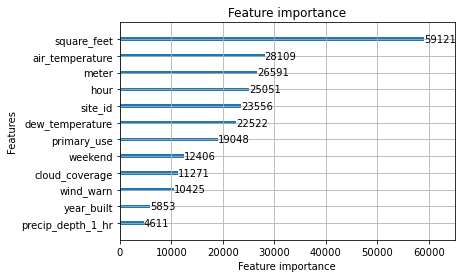

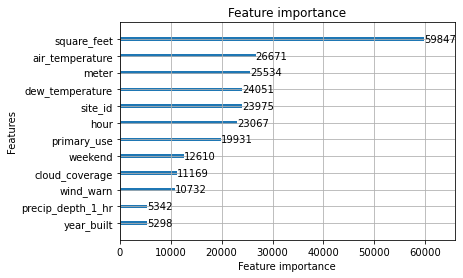

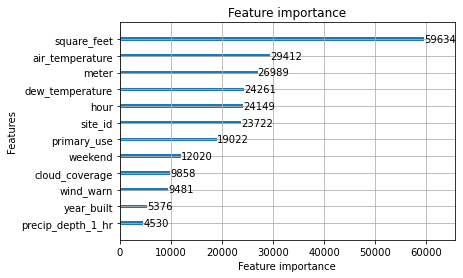

In [13]:
# 学習結果をプロット
for model in models:
    lgb.plot_importance(model)
    plt.show()
    # lgb.create_tree_digraph(model)

In [22]:
# テストデータ読み込み
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
row_ids = test_df["row_id"]
test_df.drop("row_id", axis=1, inplace=True)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 954.38 MB
Memory usage after optimization is: 199.47 MB
Decreased by 79.1%


In [ ]:
# コーディング用にロード、加工したデータを保存する
# TODO:テストコードのため、要削除
# test_df.to_pickle(os.path.join(DATA_PATH, "test_df.pkl"))

In [14]:
# コーディング用に保存したデータをロードする
# TODO:テストコードのため、要削除
test_df = pd.read_pickle(os.path.join(DATA_PATH, "test_df.pkl"))

In [15]:
# ビルデータを結合
test_df = test_df.merge(building_df,left_on='building_id',right_on='building_id',how='left')
del building_df
gc.collect()

14369

In [16]:
# テスト気象データ読み込み、データを結合
weather_df = pd.read_csv(os.path.join(DATA_PATH, 'weather_test.csv'))
weather_df = fill_weather_dataset(weather_df)
weather_df = reduce_mem_usage(weather_df)

/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_2170/703020239.py:36: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  weather_df["week"] = weather_df["datetime"].dt.week


Memory usage of dataframe is 19.25 MB
Memory usage after optimization is: 8.93 MB
Decreased by 53.6%


In [ ]:
# コーディング用にロード、加工したデータを保存する
# TODO:テストコードのため、要削除
# weather_df.to_pickle(os.path.join(DATA_PATH, "weather_test_df.pkl"))

In [17]:
# コーディング用に保存したデータをロードする
# TODO:テストコードのため、要削除
weather_df = pd.read_pickle(os.path.join(DATA_PATH, "weather_test_df.pkl"))

In [18]:
# 気象データをテストデータへ結合
test_df = test_df.merge(weather_df,how='left',on=['timestamp','site_id'])
del weather_df
gc.collect()

30

In [19]:
# 特徴量を作成する
test_df = features_engineering(test_df)

In [20]:
# 推定する
results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    else:
        results += np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    # del model
    gc.collect()

/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_2170/3602265000.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if  results == []:


In [145]:
# データ、モデル削除
del test_df, models
gc.collect()

15

In [23]:
# 提出データ作成
results_df = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(results, 0, a_max=None)})
del row_ids,results
gc.collect()
results_df.to_csv("submission.csv", index=False)

In [24]:
results_df.head(20)

,row_id,meter_reading
0,0,123.849259
1,1,62.940305
2,2,9.525832
3,3,237.300438
4,4,1260.965857
5,5,62.410361
6,6,116.221314
7,7,592.043077
8,8,397.530478
9,9,307.365620


In [26]:
# 推定結果を提出
!kaggle competitions submit  -f submission.csv -m "lightGBMを用いて推定 3回目提出 一部変数をカテゴリー変数へ変更、パラメーター調整" ashrae-energy-prediction

100%|██████████████████████████████████████| 1.05G/1.05G [02:24<00:00, 7.79MB/s]
Successfully submitted to ASHRAE - Great Energy Predictor III

---

以下、テストコード

In [ ]:
# データ差異を確認
tmp_weather_df.merge(weather_df, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', 1)

/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_19513/2116604713.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  tmp_weather_df.merge(weather_df, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', 1)


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
139773,1,2016-02-15 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139774,1,2016-02-15 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139775,1,2016-02-15 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139776,1,2016-02-15 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139777,1,2016-02-15 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
140539,15,2016-12-09 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140540,15,2016-12-17 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140541,15,2016-12-20 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140542,15,2016-12-24 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

np.log1p(0)

0.0

In [ ]:
# 風向きが0のデータは風速が0のデータであることを確認
weather_df.query("wind_direction == 0 and wind_speed != 0")

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed


In [65]:
from matplotlib import pyplot

def plotMeterByYearBuilt(df: pd.DataFrame) -> None :
    """建築年とメーター値の散布図を作成する

    Args:
        df (pd.DataFrame): データ
    """
    
    fig, axes = pyplot.subplots(nrows=4, ncols=1, sharex=False)

    cnt = 0
    for ctg in [0, 1, 2 ,3]:
      plotDf = df.query(f"meter == {ctg}")
      axes[cnt].scatter(plotDf["year_built"], plotDf["meter_reading"])
      
      cnt += 1
      del plotDf
    
    fig.tight_layout()
    plt.show()


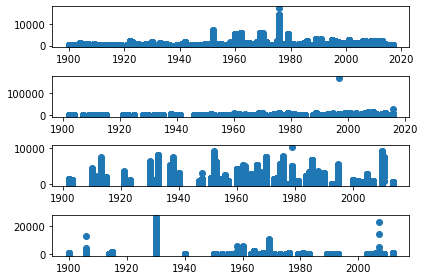

In [ ]:
# 建築年数は直接関係しない模様
plotMeterByYearBuilt(train_df)

In [69]:
from matplotlib import pyplot

def meterMeanByYearBuilt(df: pd.DataFrame) -> None :
    """メーター値の平均値を築年の設定有無毎に算出する

    Args:
        df (pd.DataFrame): データ
    """

    for ctg in [0, 1, 2 ,3]:
      yearBuiltSetDf = df.query(f"meter == {ctg} and year_built == year_built")
      yearBuiltNotSetDf = df.query(f"meter == {ctg} and year_built != year_built")

      yearBuiltSetMean =yearBuiltSetDf["meter_reading"].mean()
      yearBuiltNotSetMean =yearBuiltNotSetDf["meter_reading"].mean()

      print(f"Category: {ctg}")  
      print(f"YearBuiltSetMean: {yearBuiltSetMean}")  
      print(f"YearBuiltNotSetMean: {yearBuiltNotSetMean}")  
      
      del yearBuiltSetDf, yearBuiltNotSetDf, yearBuiltSetMean, yearBuiltNotSetMean
    

In [74]:
meterMeanByYearBuilt(train_df)

Category: 0
YearBuiltSetMean: 209.427490234375
YearBuiltNotSetMean: 148.044677734375
Category: 1
YearBuiltSetMean: 534.3399658203125
YearBuiltNotSetMean: 681.2288818359375
Category: 2
YearBuiltSetMean: 782.62548828125
YearBuiltNotSetMean: 1715.304931640625
Category: 3
YearBuiltSetMean: 186.57418823242188
YearBuiltNotSetMean: 547.9810180664062


In [75]:
from matplotlib import pyplot

def plotMeterByYearBuiltSet(df: pd.DataFrame) -> None :
    """建築年とメーター値の散布図を作成する

    Args:
        df (pd.DataFrame): データ
    """
    
    fig, axes = pyplot.subplots(nrows=4, ncols=2, sharex=False)

    cnt = 0
    for ctg in [0, 1, 2 ,3]:
      yearBuiltSetDf = df.query(f"meter == {ctg} and year_built == year_built")
      yearBuiltNotSetDf = df.query(f"meter == {ctg} and year_built != year_built")

      axes[cnt, 0].hist(yearBuiltSetDf["meter_reading"])
      axes[cnt, 1].hist(yearBuiltNotSetDf["meter_reading"])
      
      cnt += 1
      del yearBuiltSetDf, yearBuiltNotSetDf
    
    fig.tight_layout()
    plt.show()


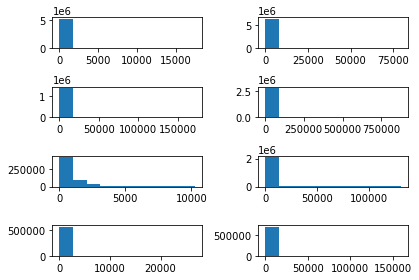

In [76]:
plotMeterByYearBuiltSet(train_df)

In [79]:
def meterStaticsByYearBuilt(df: pd.DataFrame) -> None :
    for ctg in [0, 1, 2 ,3]:
      yearBuiltSetDf = df.query(f"meter == {ctg} and year_built == year_built")
      yearBuiltNotSetDf = df.query(f"meter == {ctg} and year_built != year_built")
      print(f"Category: {ctg}")  
      print(f"YearBuiltSet")
      print(yearBuiltSetDf["meter_reading"].describe())
      print(f"YearBuiltNotSet")
      print(yearBuiltNotSetDf["meter_reading"].describe())
      
      del yearBuiltSetDf, yearBuiltNotSetDf
    

In [81]:
# 
meterStaticsByYearBuilt(train_df)

Category: 0
YearBuiltSet
count    5.244763e+06
mean     2.094275e+02
std      4.735475e+02
min      0.000000e+00
25%      2.307000e+01
50%      7.810000e+01
75%      1.991750e+02
max      1.750210e+04
Name: meter_reading, dtype: float64
YearBuiltNotSet
count    6.461253e+06
mean     1.480447e+02
std      2.917258e+02
min      0.000000e+00
25%      2.131500e+01
50%      5.891670e+01
75%      1.553000e+02
max      7.976900e+04
Name: meter_reading, dtype: float64
Category: 1
YearBuiltSet
count    1.362881e+06
mean     5.343400e+02
std      1.216988e+03
min      0.000000e+00
25%      1.654710e+01
50%      1.074800e+02
75%      4.221040e+02
max      1.726110e+05
Name: meter_reading, dtype: float64
YearBuiltNotSet
count    2.819559e+06
mean     6.812289e+02
std      9.691904e+03
min      0.000000e+00
25%      7.631600e+00
50%      1.270000e+02
75%      4.833910e+02
max      8.803740e+05
Name: meter_reading, dtype: float64
Category: 2
YearBuiltSet
count    567697.000000
mean        782.625488